# scVI-tools (single-cell variational inference tools)
[공식 문서](https://docs.scvi-tools.org/en/stable/user_guide/index.html)

In [1]:
import scanpy as sc
import scvi
from matplotlib import rcParams

# Load data

In [2]:
# folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc/"
folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2/"
adata = sc.read(folder_path + "preprocessed_adata.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 155636 × 29597
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'
    var: 'n_cells'
    layers: 'counts'

In [4]:
sc.pp.filter_genes(adata, min_cells=30)
adata

AnnData object with n_obs × n_vars = 155636 × 26295
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'
    var: 'n_cells'
    layers: 'counts'

In [12]:
adata.obs.groupby(['sample']).count().n_genes
# adata.obs.groupby(['condition']).count()

C:\Users\heung\AppData\Local\Temp\ipykernel_54068\3723676480.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(['sample']).count().n_genes


sample
SF10099       460
SF10432       366
SF10857      2130
SF11082      3356
SF11344      4696
             ... 
SF12594      3294
SF12774      2957
SF9791       1305
SF6118v2      415
SF12704v2    3417
Name: n_genes, Length: 71, dtype: int64

# batch 확인

In [13]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
# running time: 2m 8s (sc)
# running time: 


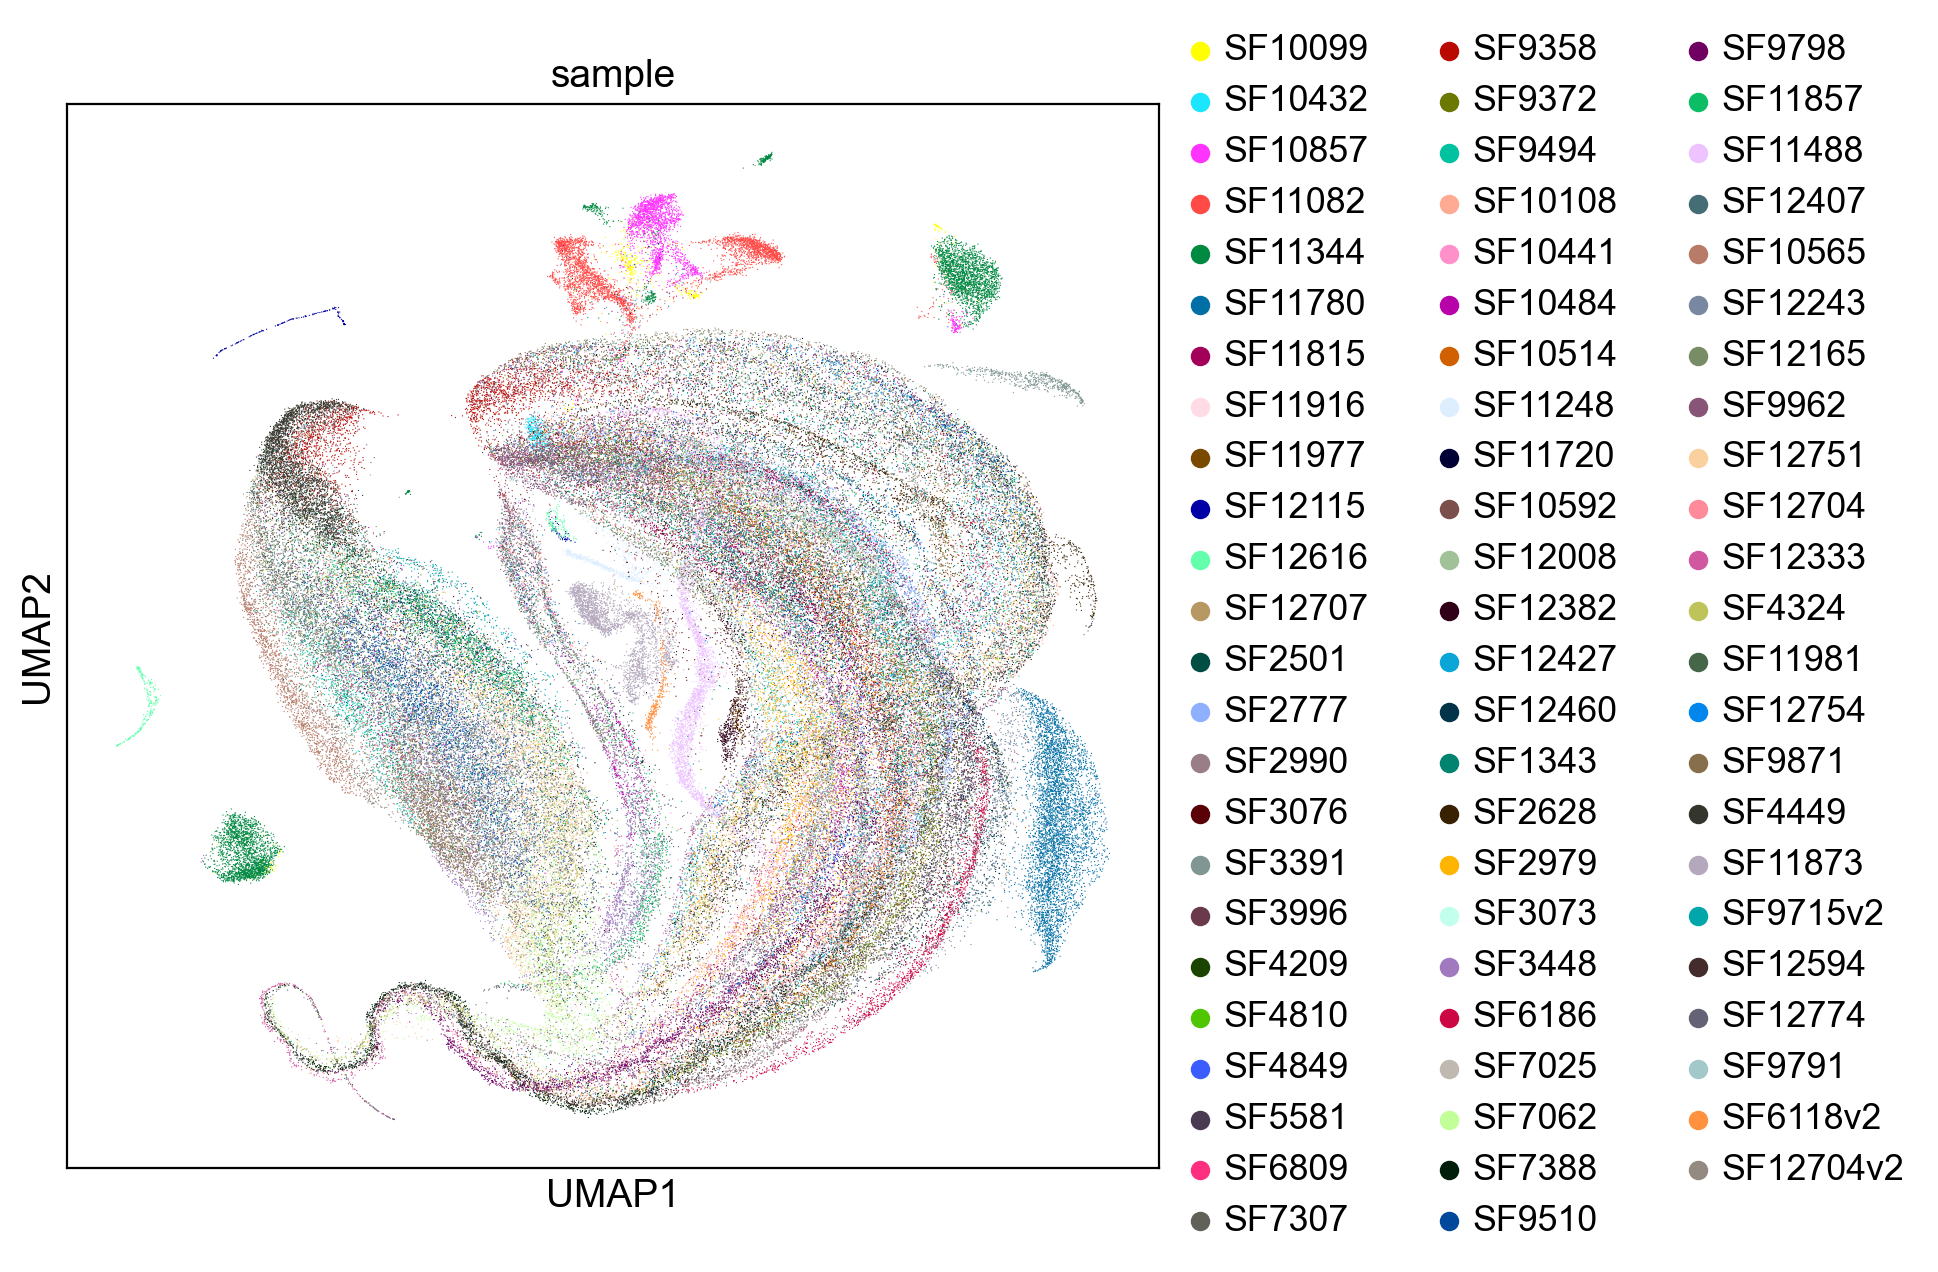

In [21]:
sc.settings.set_figure_params(dpi=100, figsize = (7, 7))
sc.pl.umap(
    adata,
    color = 'sample',
    # groups = ['SF10432', 'SF9372']
)

# Batch effect correction by scVI

In [ ]:
# pick the top 3000 highly variable genes
# you can pick more if you had more cells
# 3000 genes in 10000 cells is a good number
# gene 개수가 cell 개수의 절반은 되야 한다는 카더라가 있음
# **나는 안돌림**
sc.pp.highly_variable_genes(adata, n_top_genes = 3000, subset = True, layer = 'counts',
                            flavor = 'seurat_v3', batch_key = 'condition')

In [28]:
# making the scVI model
# GPU 안쓰면 개느림. Cuda <- 필수
# 37k cells and 16k genes, 215 epochs, RTX3070 -> 약 11분 소요
# 143k cells and 30k genes, 56 epochs, RTX3070 -> 약 18분 소요
scvi.model.SCVI.setup_anndata(
    adata,
    layer = 'counts',
    continuous_covariate_keys = ['pct_counts_mito', 'pct_counts_ribo', 'total_counts'],
    batch_key = 'sample'
)
model = scvi.model.SCVI(
    adata,
    n_layers = 4,
    n_latent = 60,
    gene_likelihood = 'nb',
)


c:\Users\heung\anaconda3\Lib\site-packages\scvi\data\fields\_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [29]:
# model.train(max_epochs = 200)
model.train(max_epochs = 100)
# init train loss = 5.1e+3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\heung\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|██████████| 100/100 [23:14<00:00, 13.96s/it, v_num=1, train_loss_step=4.78e+3, train_loss_epoch=4.91e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [23:14<00:00, 13.95s/it, v_num=1, train_loss_step=4.78e+3, train_loss_epoch=4.91e+3]


In [30]:
# get the latent space
adata.obsm['X_scVI'] = model.get_latent_representation()
# model.get_latent_representation().shape

# get scVI normalized data
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

# running time: 40s
# running time: 26s

# Batch regression 확인

In [31]:
# 기본적인 clustering
# sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep = 'X_scVI')
sc.tl.umap(adata)

# running time: 1m 51s
# running time: 1m 37s

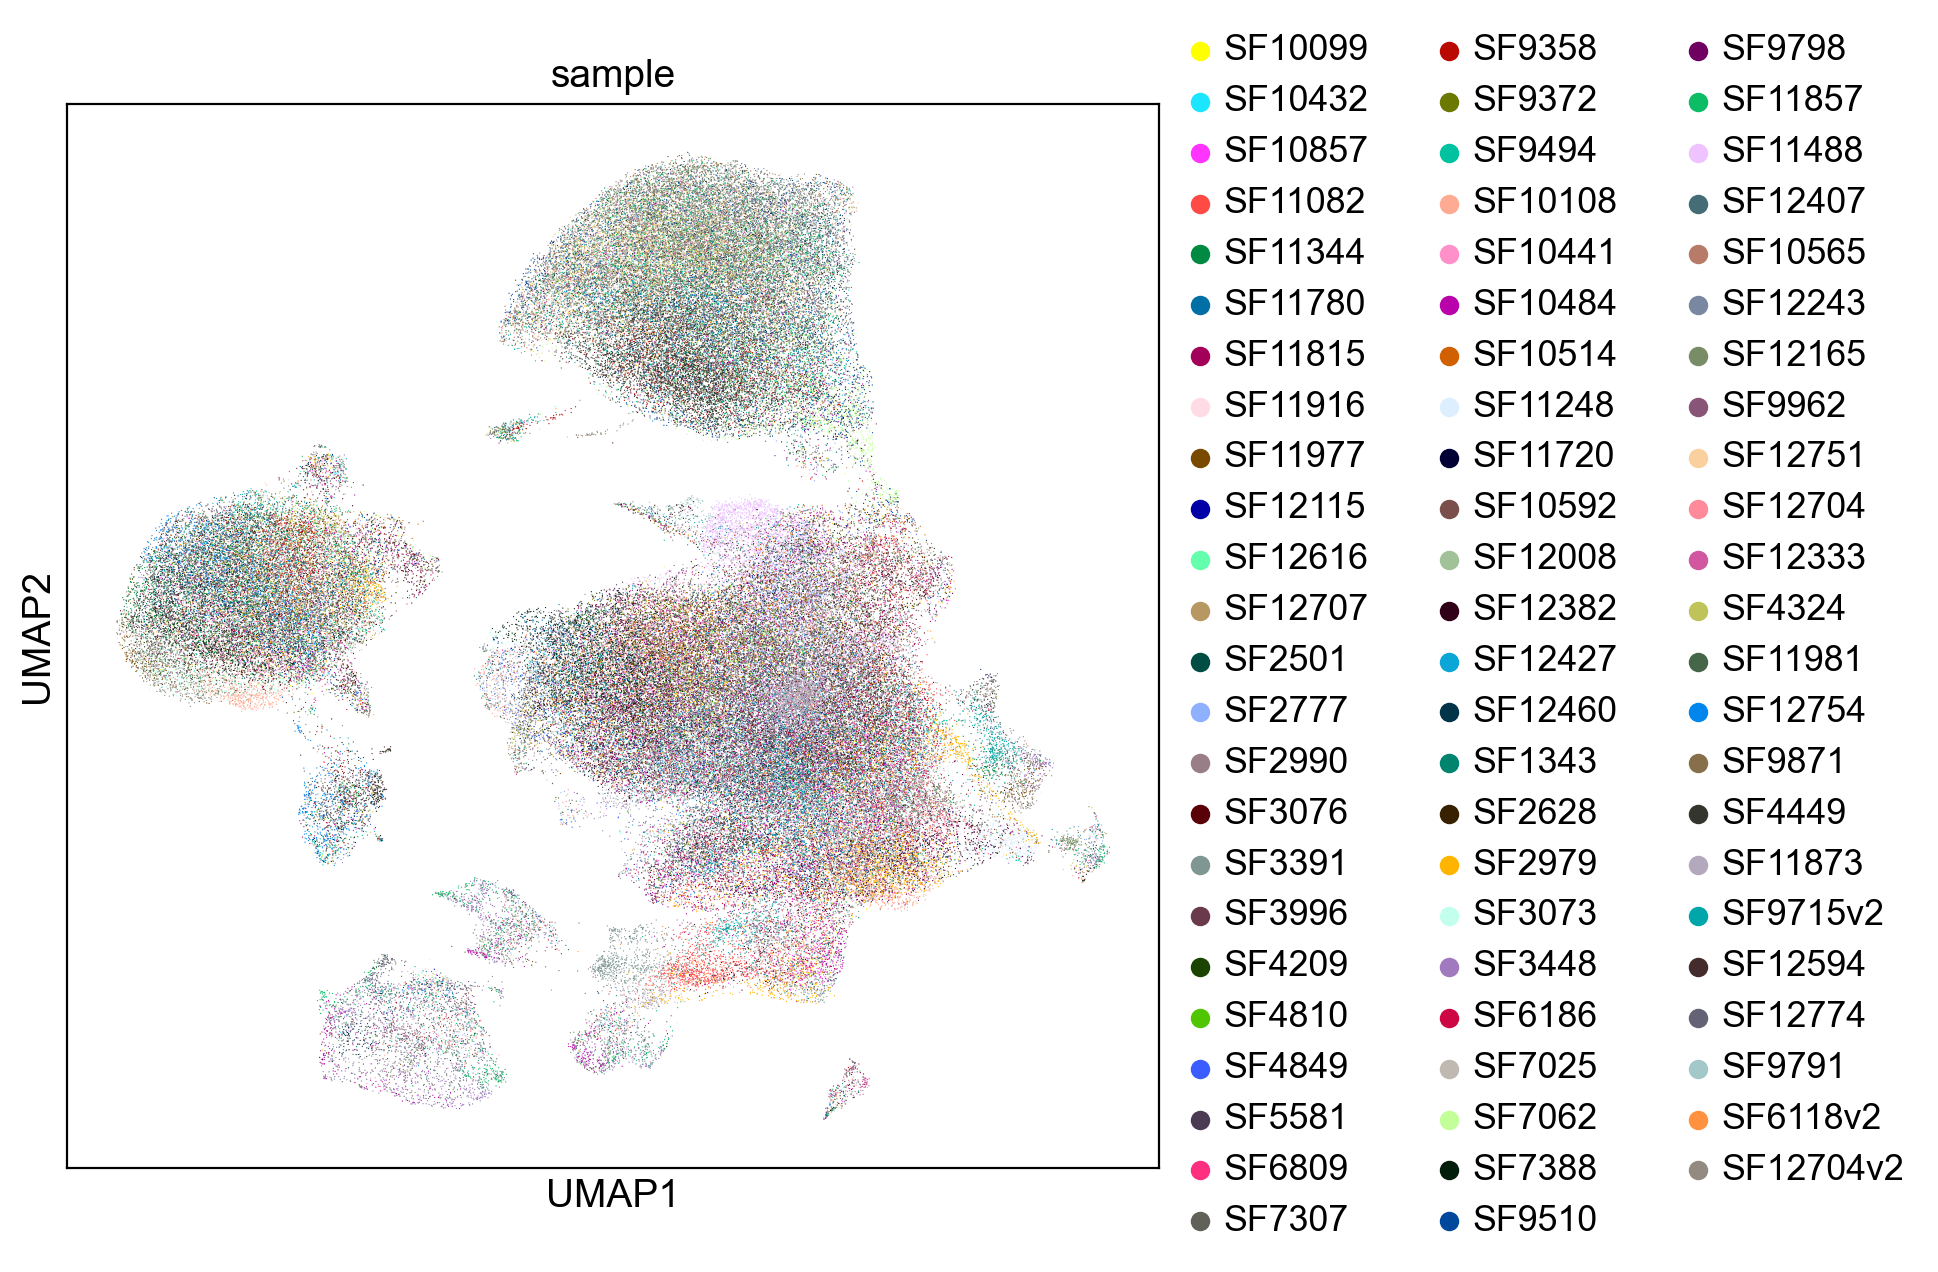

In [32]:
sc.settings.set_figure_params(dpi=100, figsize = (7, 7))

sc.pl.umap(
    adata,
    color = ['sample'],
    # groups = ['Pt1'],
)

In [31]:
adata

AnnData object with n_obs × n_vars = 126563 × 41541
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels'
    var: 'n_cells'
    uns: 'sample_colors', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', '_scvi_extra_continuous_covs', 'X_scVI'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

# Save the integrated data and scVI model

In [32]:
adata.write_h5ad(folder_path + "adata_scVI.h5ad")
model.save(folder_path + 'model/')  # trained model 저장